# Histopathologic Cancer Detection


In the images below you can find eight image patches of pathology scans. Some contain cancer cells, others don't. Would you be able to identify the images containing cancer cells? Probably not.


<img src="images/alle_unlabeled.png" width="500"/>
</p>

To be fair, you are probably not a doctor so you could only make a more or less educated guess. However also a doctor would take a considerable amount of time to go through these images and determine wether the patient is sick or not.

That's what this project is for. We want to train a neural network that takes these patches of scans as input and returns them with a label "1" for cancer or "0" for healthy. Since it would only be a pre evaluation and an actual doctor would have a look at all images labeled "1" to verify the result, the goal is a low false negative rate. In general we are aiming for an accuracy higher than 90%.

In [17]:
# importing the needed packages
import keras
from keras.layers.core import Layer
import tensorflow as tf
from keras import layers
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import MaxPool2D, Flatten, BatchNormalization,Reshape,Activation, GlobalMaxPooling2D, ZeroPadding2D,add
from keras.layers import SeparableConv2D, UpSampling2D, Add, Subtract

from tensorflow import fill

import numpy as np 
from keras import backend as K 
from keras.utils import np_utils

import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint, CSVLogger
import pandas as pd
from glob import glob
import os

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras
from keras.utils import plot_model

import matplotlib.pyplot as plt

In [2]:
#Hyperparameters for future use
SAMPLE_COUNT = 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
BATCH_SIZE =32
VERBOSITY = 1

First we load the data and save the path and the ID of all images in a pandas dataframe.

In [3]:
#load Data
input_dir = 'data/'
training_dir = os.path.join(input_dir + 'train/')
#training_dir = '/data/train'
data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
#get id, data_frame.path is series
data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[1].split('\\')[1].split('.')[0])

KeyboardInterrupt: 

Since the labels are stored in a csv file separate from our data, we need to merge them for training. Then we split the dataset into training and validation data while making sure that we have the same amount of images for each class. Afterwards we reset the indexes so that they are sequential before splitting the dataset.

In [ ]:
#add trainingset label
labels = pd.read_csv(input_dir + 'train_labels.csv')
data_frame = data_frame.merge(labels, on='id')

In [ ]:
#sample
negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)

In [ ]:
# use reset_index() to get new sequential index
data_frame = pd.concat([negatives,positives]).reset_index()
data_frame = data_frame[['path','id','label']]

In [ ]:
# split dataset
from sklearn.model_selection import train_test_split
import shutil
training_path = 'data/training/'
validation_path = 'data/validation/'

for folder in [training_path, validation_path]:
    for subfolder in ['0', '1']:
        path = os.path.join(folder, subfolder)
        os.makedirs(path, exist_ok=True)

training, validation = train_test_split(data_frame, train_size=0.7, stratify=data_frame['label'])

data_frame.set_index('id', inplace=True)
for images_and_path in [(training, training_path), (validation, validation_path)]:
    images = images_and_path[0]
    path = images_and_path[1]
    for image in images['id'].values:
        file_name = image + '.tif'
        label = str(data_frame.loc[image,'label'])
        destination = os.path.join(path, label, file_name)
        if not os.path.exists(destination):
            source = os.path.join(input_dir + 'train', file_name)
            shutil.copyfile(source, destination)

In [1]:
# filepath for future use
training_path = 'data/training/'
validation_path = 'data/validation/'

The dataset is already considerably large but since we want to use a deep network, we are going to augment our data nonetheless, to get even more data for training. We are also rescaling the images to values between zero and one to limit false influences on our model.

In [ ]:
#Data Augmentation
training_data_generator = ImageDataGenerator(rescale=1./255,
                                             horizontal_flip=True,
                                             vertical_flip=True,
                                             rotation_range=180,
                                             zoom_range=0.4,
                                             width_shift_range=0.3,
                                             height_shift_range=0.3,
                                             shear_range=0.3,
                                             channel_shift_range=0.3)

In [ ]:
training_generator = training_data_generator.flow_from_directory(training_path,
                                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                batch_size = BATCH_SIZE,
                                                                class_mode='binary')

validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                              target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                              batch_size=BATCH_SIZE,
                                                                              class_mode='binary')

testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                           target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                                           batch_size=BATCH_SIZE,
                                                                           class_mode='binary',
                                                                           shuffle=False)

# ResNet50

The first model structure we are going to use is a ResNet50. It was the first model to introduce the residual function which is an important idea for deep networks. The deeper the network the more we run into the problem of the accuracy saturating or even decreasing because information gets lost along the way. In the ResNet50 this problem is solved by applying gradient propagation with residual functions.

<img src="images/ResNetBlock.png" width="500"/>
<p style="text-align: center;">
    Basis of the ResNet model
</p>

In [6]:
#module of structure of neural network (Resnet 50)
def Conv2d_BN(Input_tensor,stage, block, n_filter, kernel_size, strides, n_serials , padding='valid'):
    #stage: integer, current stage label, used for generating layer names
    #block: 'a','b'....,current block label, used for generating layer names
    #n_serial: used for generating layer names
    conv_name_base = 'res_' + str(stage)+ block + '_branch'
    bn_name_base = 'bn_' + str(stage) + block +  '_branch'
    x = Conv2D(n_filter, kernel_size, padding=padding,strides=strides,activation='relu',kernel_initializer='he_normal', name=conv_name_base+n_serials)(Input_tensor)
    x = BatchNormalization(name=bn_name_base+n_serials)(x)
    return x

def identity_Block(Input_tensor, n_filters, kernel_size, strides, stage, block, with_conv_shortcut):
    #kernel_size: default=3
    filter1, filter2, filter3 = n_filters
    conv_name_base = 'res' + str(stage)+ block + '_branch'
    x = Conv2d_BN(Input_tensor, stage, block, n_filter=filter1, kernel_size=1, strides=strides,n_serials='_a')
    x = Conv2d_BN(x,stage, block,n_filter=filter2, kernel_size=kernel_size,strides=(1,1), n_serials='_b', padding='same')
    x = Conv2d_BN(x,stage, block, n_filter=filter3, kernel_size=1,strides=(1,1), n_serials='_c')
    
    if with_conv_shortcut:
        shortcut = Conv2d_BN(Input_tensor, stage, block, n_filter=filter3, kernel_size=1,strides=strides, n_serials='short_cut')
        x = add([x,shortcut])
    else:
        x = add([x,Input_tensor])
        
    return x

In [7]:
def model_Resnet(FC=True):
    input_layer = Input(shape=(96,96,3),name='input_layer')
    #stage 1
    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(input_layer)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    
    #stage 2
    x = identity_Block(x, n_filters=[64, 64, 256], kernel_size=3, strides=(1,1), stage=2, block='a', with_conv_shortcut=True)
    x = identity_Block(x, n_filters=[64, 64, 256], kernel_size=3, strides=(1,1), stage=2, block='b', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[64, 64, 256], kernel_size=3, strides=(1,1), stage=2, block='c', with_conv_shortcut=False)
    
    #stage 3
    x = identity_Block(x, n_filters=[128, 128, 512], kernel_size=3, strides=(2,2), stage=3, block='a', with_conv_shortcut=True)
    x = identity_Block(x, n_filters=[128, 128, 512], kernel_size=3, strides=(1,1), stage=3, block='b', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[128, 128, 512], kernel_size=3, strides=(1,1), stage=3, block='c', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[128, 128, 512], kernel_size=3, strides=(1,1), stage=3, block='d', with_conv_shortcut=False) 
    
    #stage4
    x = identity_Block(x, n_filters=[256, 256, 1024], kernel_size=3, strides=(2,2), stage=4, block='a', with_conv_shortcut=True)
    x = identity_Block(x, n_filters=[256, 256, 1024], kernel_size=3, strides=(1,1), stage=4, block='b', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[256, 256, 1024], kernel_size=3, strides=(1,1), stage=4, block='c', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[256, 256, 1024], kernel_size=3, strides=(1,1), stage=4, block='d', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[256, 256, 1024], kernel_size=3, strides=(1,1), stage=4, block='e', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[256, 256, 1024], kernel_size=3, strides=(1,1), stage=4, block='f', with_conv_shortcut=False)
    
    #stage 5
    x = identity_Block(x, n_filters=[512, 512, 2048], kernel_size=3, strides=(2,2), stage=5, block='a', with_conv_shortcut=True)
    x = identity_Block(x, n_filters=[512, 512, 2048], kernel_size=3, strides=(1,1), stage=5, block='b', with_conv_shortcut=False)
    x = identity_Block(x, n_filters=[512, 512, 2048], kernel_size=3, strides=(1,1), stage=5, block='c', with_conv_shortcut=False)
    
    if FC:
        x = GlobalAveragePooling2D()(x)
        x = layers.Dropout(0.5)(x)
        x = Dense(1, activation='sigmoid', name='fc1000')(x)
    
    model = Model(input_layer,x,name='Resnet50')
    return model

In [8]:
model = model_Resnet()
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='ResNet_model.png')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_layer[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormal

In [ ]:
Resnet_model = model_Resnet()
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-5, amsgrad=False)# learning-rate decay
Resnet_model.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer=Adam)

config_resnet = 'Res_aug' #give a recognizable name
resnet_logger = TensorBoard(log_dir='logs/'+config_resnet+'/')
csv_logger = CSVLogger('training_Resnet_acc.log') 


history = Resnet_model.fit_generator(training_generator, 
                          steps_per_epoch=len(training_generator),
                          validation_data=validation_generator,
                          validation_steps=len(validation_generator),
                          epochs=70,
                          verbose=VERBOSITY,
                          callbacks=[PlotLossesKeras(),csv_logger,
                                     ModelCheckpoint('model/Resnet/'+'model_Resnet_acc',
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),resnet_logger])

<img src="images/ResNet.png" width="500"/>
<p style="text-align: center;">
    Accuracy of the ResNet50
</p>

# DenseNet

The DenseNet uses the same idea as the ResNet of forwarding already learned information to new layers. However instead of using a residual function it directly concatenates the output of each layer with the outputs of the following layers. This helps in reducing the issue of vanishing gradients by enforcing feature propagation. Since the outputs of several layers are concatenated it also increases the variation of the inputs and thereby increases the accuracy. 

Simply put, each layer benefits from the already collected knowledge of all previous layers.

Furthermore it uses 1x1 kernels as transition layers to compress the size of the channel and making for efficient. 

<img src="images/DenseBlock.png" width="500"/>
<p style="text-align: center;">
    Structure of the Dense model
</p>

In [9]:
#Dense net
from keras import backend
def Dense_block(x, blocks, name):
#     Arguemnts
#     x: input tensor
#     block: integer, the number of building blocks
#     name: string, block label
    for i in range(blocks):
        x=conv_block(x, 32, name=name + '_block' + str(i+1))
    return x

def transition_block(x, reduction, name):
#     Arguments
#     x: input tensor'
#     reduction: float,compression rate at transition layers
#     name: string, block label
      
#     returns
#     outputtensor for the block
    bn_axis = -1
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_bn')(x)
    x = layers.Activation('relu', name = name + '_relu')(x)
    x = layers.Conv2D(int(backend.int_shape(x)[bn_axis]*reduction), 1, use_bias=False, name=name+'_conv')(x)
    x = layers.AveragePooling2D(2, strides=2, name=name + '_pool')(x)
    
    return x

def conv_block(x, growth_rate, name):
#     Argument
#       x: input tensor
#       growth rate: float, growth rate at dense layers
#       name: string, block label
    
#     Returns
#       Output tensor for the block
    bn_axis = -1
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(x)
    
    x1 = layers.Activation('relu', name=name + '_0_relu')(x1)
    x1 = layers.Conv2D(4*growth_rate, 1, use_bias=False, name=name + '_1_conv')(x1)
    x1 = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x1)
    x1 = layers.Activation('relu', name=name + '_1_relu')(x1)
    x1 = layers.Conv2D(growth_rate, 3, padding='same', use_bias=False, name=name + '_2_conv')(x1)
    
    x = layers.Concatenate(axis=bn_axis, name=name + '_concat')([x,x1])
    
    return x

In [12]:
def model_DenseNet(blocks=[6,12,32,32],FC=True):
    input_layer = Input(shape=(96,96,3),name='input_layer_DenseNet')
    
    bn_axis = -1
    
    x = layers.ZeroPadding2D(padding=((3,3),(3,3)))(input_layer)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.ZeroPadding2D(padding=((1,1),(1,1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)
    
    x = Dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = Dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = Dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = Dense_block(x, blocks[2], name='conv5')
    
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Activation('relu', name='relu')(x)
    
    if FC:
        x = GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dropout(0.5)(x)
        x = Dense(1, activation='sigmoid', name='fc1000')(x)
    
    model = Model(input_layer,x,name='Densenet_169')
    return model

In [13]:
model = model_DenseNet()
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='DenseNet_model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_DenseNet (InputLaye (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 102, 102, 3)  0           input_layer_DenseNet[0][0]       
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv5_block23_1_bn (BatchNormal (None, 3, 3, 128)    512         conv5_block23_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block23_1_relu (Activatio (None, 3, 3, 128)    0           conv5_block23_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block23_2_conv (Conv2D)   (None, 3, 3, 32)     36864       conv5_block23_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block23_concat (Concatena (None, 3, 3, 1376)   0           conv5_block22_concat[0][0]       
                                                                 conv5_block23_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block24_0_bn (BatchNormal (None, 3, 3, 1376)   5504        conv5_block23_concat[0][0]       
__________

In [ ]:
model_Dense = DenseNet()
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False)# learning-rate decay
model_Dense.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer=Adam)

config_resnet = 'Dense' #give a recognizable name
resnet_logger = TensorBoard(log_dir='logs/'+config_resnet+'/')
csv_logger = CSVLogger('training_Dense_acc_2.log') 


history = model_Dense.fit_generator(training_generator, 
                          steps_per_epoch=len(training_generator),
                          validation_data=validation_generator,
                          validation_steps=len(validation_generator),
                          epochs=70,
                          verbose=VERBOSITY,
                          callbacks=[PlotLossesKeras(),csv_logger,
                                     ModelCheckpoint('model/Dense/'+'model_Dense_acc_2',
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),resnet_logger])

<img src="images/Dense.png" width="500"/>
<p style="text-align: center;">
    Accuracy of the DenseNet
</p>

# Fusion

For the fusion there are three different possibilities: 

1. Pre-training the models and freezing them before training the fusion
2. Using pre-trained weights for the initilization of the fusion without freezing the models
3. Training both models and the fusion from scratch

In all cases we need to delete the classification layers of the models and concatenate the feature layers of the models, followed by a dropout layer and a dense layer.

In [16]:
Resnet_model = model_Resnet(FC=False)

In [ ]:
#load weights
Resnet_model.load_weights('model/Resnet/model_Resnet_acc',by_name=True)

In [ ]:
#freeze model
for layer in Resnet_model.layers:
    layer.trainable = False

In [17]:
Dense_model = DenseNet(FC=False)

In [ ]:
#load a part of weights
Dense_model.load_weights('model/Dense/model_Dense_acc_2',by_name=True)

In [ ]:
#freeze model
for layer in Dense_model.layers:
    layer.trainable = False

In [18]:
def fusion_model(Resnet_model,Dense_model):
    inputs = Input(shape=(96,96,3),name='input_layer_fusion')
    Resnet = Resnet_model(inputs)
    DenseNet = Dense_model(inputs)
    
    outputs =  layers.Concatenate(axis=-1,name='fusion_concate')([GlobalAveragePooling2D(name='GA_res')(Resnet), GlobalAveragePooling2D(name='GA_dense')(DenseNet)])
    outputs = Dropout(0.5, name='fusion_dr')(outputs)
    outputs = Dense(1, activation='sigmoid')(outputs)
    
    model = Model(inputs, outputs, name='Fusion_net')
    
    return model

In [20]:
fusion = fusion_model(Resnet_model, Dense_model)
# model summary
fusion.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='DenseNet_model.png')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer_fusion (InputLayer) (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
Resnet50 (Model)                (None, 3, 3, 2048)   23587712    input_layer_fusion[0][0]         
__________________________________________________________________________________________________
Densenet_169 (Model)            (None, 3, 3, 1664)   12642880    input_layer_fusion[0][0]         
__________________________________________________________________________________________________
GA_res (GlobalAveragePooling2D) (None, 2048)         0           Resnet50[2][0]                   
__________________________________________________________________________________________________
GA_dense (

In [ ]:
#compile and fit
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False)# learning-rate decay
fusion.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer=Adam)

config = 'fusion' #give a recognizable name
fusion_logger = TensorBoard(log_dir='logs/'+config+'/')
csv_logger = CSVLogger('training_fusion.log') 


history = fusion.fit_generator(training_generator, 
                          steps_per_epoch=len(training_generator),
                          validation_data=validation_generator,
                          validation_steps=len(validation_generator),
                          epochs=100,
                          verbose=VERBOSITY,
                          callbacks=[PlotLossesKeras(),csv_logger,
                                     ModelCheckpoint('model/fusion/'+'model_fusion',
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),fusion_logger])

<img src="images/Fusion.png" width="500"/>
<p style="text-align: center;">
    Accuracy of the fusion with frozen models
</p>

<img src="images/Fusion_full.png" width="500"/>
<p style="text-align: center;">
    Accuracy of the fusion with pretrained weights & without freezing the models
</p>

# Xception

The Xception model is an extension of the Inception model. The incpetion model uses modules of parallel convolutional layers with different kernel sizes which are then concatenated. Furthermore a 1x1 convolutional layer is added before each convolutional layer to limit the number of channels and thereby decreasing the computational cost. In the Xception model these Inception modules are replaced with depthwise separable convolutional layers. These layers help to decrease the computational cost siginificantly. The Xception model also uses residual connections for better feature propagation.

<img src="images/XceptionBlock.png" width="500"/>
<p style="text-align: center;">
    Depthwise separable convolutional layer
</p>

In [1]:
def entry_flow(inputs) :

    x = Conv2D(32, 3, strides = 2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64,3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    block_result = x

    for size in [128, 256, 728] :

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(size, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = MaxPooling2D(3, strides=2, padding='same')(x)

        res = Conv2D(size, 1, strides=2, padding='same')(block_result)

        x = Add()([x, res])
        block_result = x

    return x

def middle_flow(x, num_blocks=8) :

    block_result = x

    for i in range(num_blocks) :

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, block_result])
        block_result = x

    return x

def exit_flow(x) :

    block_result = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x) 
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    res = Conv2D(1024, 1, strides=2, padding='same')(block_result)
    x = Add()([x, res])

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)

    return x

In [2]:
def model_Xception():
    
    input_layer = Input(shape=(96,96,3),name='input_layer')

    x = entry_flow(input_layer)
    x = middle_flow(x)
    x = exit_flow(x)
    
    model = Model(input_layer, x, name='xception')
    
    return model

In [5]:
model = model_Xception()
# summarize model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='xception_model.png')

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 32)   896         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 48, 48, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 48, 48, 32)   0           batch_normalization_1[0][0]      
_____________________________________

In [ ]:
xception = model
Adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-4, amsgrad=False)# learning-rate decay
xception.compile(loss='binary_crossentropy', metrics = ['accuracy'], optimizer=Adam)

config_resnet = 'Xception' #give a recognizable name
resnet_logger = TensorBoard(log_dir='logs/'+config_resnet+'/')
csv_logger = CSVLogger('training_Xception.log') 


history = xception.fit_generator(training_generator, 
                          steps_per_epoch=len(training_generator),
                          validation_data=validation_generator,
                          validation_steps=len(validation_generator),
                          epochs=60,
                          verbose=VERBOSITY,
                          callbacks=[PlotLossesKeras(),csv_logger,
                                     ModelCheckpoint('model/Xception/'+'model_Xception',
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),resnet_logger])

<img src="images/Xception.png" width="500"/>
<p style="text-align: center;">
    Accuracy of the Xception
</p>

# Plotting the results

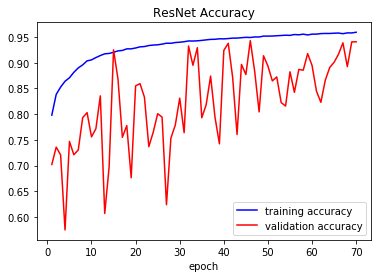

In [20]:
#plot for loss or accuracy
path='training_Resnet_acc.log'
history_Resnet= pd.read_csv(path)
epochs = [i for i in range(1,len(history_Resnet['epoch'])+1)]
plt.plot(epochs, history_Resnet['acc'], color='blue', label="training accuracy")
plt.plot(epochs, history_Resnet['val_acc'], color='red', label="validation accuracy")
plt.legend(loc='best')
plt.title('ResNet Accuracy')
plt.xlabel('epoch')
plt.savefig('ResNet.png')
plt.show()

## Confusion Matrix

In [ ]:
from keras.models import load_model
path_Dense = 'model/Dense/model_Dense_acc_2'
model=load_model(path_Dense)

In [ ]:
predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=1)

In [ ]:
#reduce dimension: same dimension with testing_generator.classes.shape
predictions=np.around(np.squeeze(predictions, axis=1))

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(testing_generator.classes, predictions,labels=[0,1])

In [ ]:
plot_cm = pd.DataFrame({'prediction_0':cm[:,0]})
plot_cm['prediction_1']=cm[:,1]
plot_cm.index=['actual_0','actual_1']

In [ ]:
import seaborn as sns
ax=sns.heatmap(plot_cm,annot=True,fmt='d')
ax.set_title('confusion_matrix')

# Conclusion

We successfully trained three models and each model had a validation accuracy above 90%. The idea of mergeing several models also seems to pay off resulting in an even higher accuracy. In the next step it would be interesting to include the Xception model into the fusion as well to see how the results change. Furthermore the amount of information we give as input to the fusion can be optimized. Maybe saving the models after every 10 epochs and using those weights as initalization for the fusion leads to a more generalized result.